We shall now try to train some models on the dataset r2.

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data loading

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255    # not using read_image coz it can only read jpeg or png
        image = image[:,:,:3]  # dropping the alpha channel if any
        class_label = self.img_annotations.iloc[idx,2]-1      # the -1 is coz labels are expected from 0 to C-1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label

In [3]:
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize])  

In [4]:
train_r2 = PetDataset('annotations_aug/annotations_train_r2.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = trans)

In [5]:
train_r2_loader = DataLoader(train_r2,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


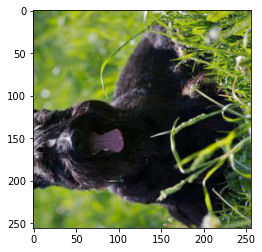

In [6]:
train_b1_img, train_b1_label = next(iter(train_r2_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model (6 conv layers)

In [7]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model2 = PetCNN6()
loss_function = nn.NLLLoss()


print(model2)
        

PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 128,

In [9]:
learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model2.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r2_loader:
        model2.train()
        out = model2(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model2.eval()
                with torch.no_grad():
                    train_r2_part = DataLoader(train_r2,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r2_part))
                    train_out = model2(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model2(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 42.34969878196716
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 43.456186056137085
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 40.06429648399353
Current training loss:3.5183041095733643
Current training accuracy:0.0625
Current validation loss:3.5106148719787598
Current validation accuracy:0.06975184381008148
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 35.87042808532715
Current training loss:3.5304293632507324
Current training accuracy:0.0546875
Current validation loss:3.5193042755126953
Current validation accuracy:0.05231388285756111
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 30.584726333618164
Current training loss:3.3792362213134766
Current training accuracy:0.07958984375
Current validation loss:3.3783376216888428
Current validation accuracy:0.08383635431528091
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 30.870126247406006
Current training lo

Current training loss:2.146446466445923
Current training accuracy:0.3984375
Current validation loss:2.6075289249420166
Current validation accuracy:0.276324599981308
Epoch:16
Iteration:1800
Time taken for the last 50 iterations: 30.61319851875305
Current training loss:2.1394567489624023
Current training accuracy:0.41943359375
Current validation loss:2.5556201934814453
Current validation accuracy:0.2857142984867096
Epoch:16
Iteration:1850
Time taken for the last 50 iterations: 30.859241485595703
Current training loss:1.960068941116333
Current training accuracy:0.47509765625
Current validation loss:2.501946449279785
Current validation accuracy:0.31924882531166077
Epoch:17
Iteration:1900
Time taken for the last 50 iterations: 30.452775478363037
Current training loss:2.056215524673462
Current training accuracy:0.42822265625
Current validation loss:2.5559847354888916
Current validation accuracy:0.29376256465911865
Epoch:17
Iteration:1950
Time taken for the last 50 iterations: 31.450165271759

Epoch:30
Iteration:3400
Time taken for the last 50 iterations: 40.651957988739014
Current training loss:1.1342406272888184
Current training accuracy:0.74609375
Current validation loss:2.371671676635742
Current validation accuracy:0.33132126927375793
Epoch:31
Iteration:3450
Time taken for the last 50 iterations: 35.99745440483093
Current training loss:1.0264517068862915
Current training accuracy:0.77978515625
Current validation loss:2.319403648376465
Current validation accuracy:0.3581489026546478
Epoch:31
Iteration:3500
Time taken for the last 50 iterations: 37.41801881790161
Current training loss:1.071700930595398
Current training accuracy:0.76611328125
Current validation loss:2.3505632877349854
Current validation accuracy:0.3454057574272156
Epoch:32
Iteration:3550
Time taken for the last 50 iterations: 36.39994978904724
Current training loss:1.0292669534683228
Current training accuracy:0.771484375
Current validation loss:2.353027105331421
Current validation accuracy:0.3561368286609649

Current validation loss:2.4093971252441406
Current validation accuracy:0.35211268067359924
Epoch:45
Iteration:5050
Time taken for the last 50 iterations: 37.89330530166626
Current training loss:0.5190056562423706
Current training accuracy:0.92529296875
Current validation loss:2.3754727840423584
Current validation accuracy:0.3581489026546478
Epoch:46
Iteration:5100
Time taken for the last 50 iterations: 34.15286374092102
Current training loss:0.5105687975883484
Current training accuracy:0.927734375
Current validation loss:2.3611786365509033
Current validation accuracy:0.3749161660671234
Epoch:46
Iteration:5150
Time taken for the last 50 iterations: 32.738579750061035
Current training loss:0.4762161672115326
Current training accuracy:0.9345703125
Current validation loss:2.348125457763672
Current validation accuracy:0.3695506453514099
Epoch:47
Iteration:5200
Time taken for the last 50 iterations: 31.313177585601807
Current training loss:0.4671632945537567
Current training accuracy:0.93164

KeyboardInterrupt: 

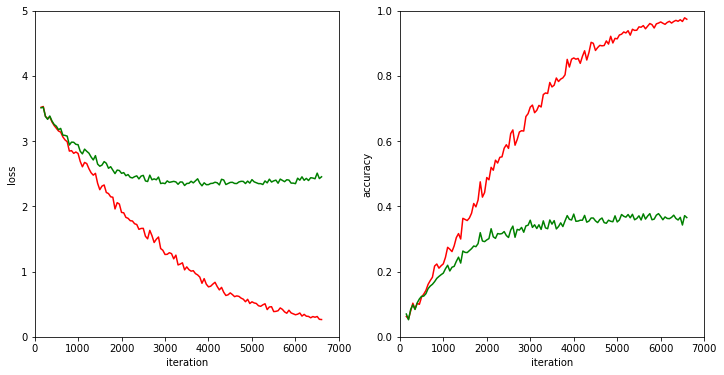

In [10]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,7000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,7000)
acc_graph.set_ylim(0,1)

plt.show()  

# Model (design 2 with 6 conv layers)

In [13]:
class PetCNN6des2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=1),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370*3*3, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model2 = PetCNN6des2()
loss_function = nn.NLLLoss()


print(model2)
        

PetCNN6des2(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 

In [14]:
learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model2.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 120

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r2_loader:
        model2.train()
        out = model2(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model2.eval()
                with torch.no_grad():
                    train_r2_part = DataLoader(train_r2,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r2_part))
                    train_out = model2(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model2(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 34.34707260131836
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 38.93700647354126
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 38.70017600059509
Current training loss:3.455451488494873
Current training accuracy:0.07568359375
Current validation loss:3.4705049991607666
Current validation accuracy:0.08115358650684357
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 38.65771245956421
Current training loss:3.4228222370147705
Current training accuracy:0.06884765625
Current validation loss:3.4874002933502197
Current validation accuracy:0.06975184381008148
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 37.90373516082764
Current training loss:3.3513638973236084
Current training accuracy:0.091796875
Current validation loss:3.3925607204437256
Current validation accuracy:0.08316566050052643
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 38.463395833969116
Current train

Current training loss:2.3454642295837402
Current training accuracy:0.34228515625
Current validation loss:2.668246030807495
Current validation accuracy:0.2488262951374054
Epoch:16
Iteration:1800
Time taken for the last 50 iterations: 41.832515478134155
Current training loss:2.454073667526245
Current training accuracy:0.31298828125
Current validation loss:2.7887837886810303
Current validation accuracy:0.23608316481113434
Epoch:16
Iteration:1850
Time taken for the last 50 iterations: 43.806135416030884
Current training loss:2.2565999031066895
Current training accuracy:0.3427734375
Current validation loss:2.652811288833618
Current validation accuracy:0.24547283351421356
Epoch:17
Iteration:1900
Time taken for the last 50 iterations: 42.90192413330078
Current training loss:2.3584213256835938
Current training accuracy:0.33349609375
Current validation loss:2.724332332611084
Current validation accuracy:0.24144868552684784
Epoch:17
Iteration:1950
Time taken for the last 50 iterations: 45.7699933

Current training loss:1.3263099193572998
Current training accuracy:0.67041015625
Current validation loss:2.5595171451568604
Current validation accuracy:0.30449363589286804
Epoch:31
Iteration:3450
Time taken for the last 50 iterations: 43.798837184906006
Current training loss:1.3234342336654663
Current training accuracy:0.6513671875
Current validation loss:2.5947914123535156
Current validation accuracy:0.30851778388023376
Epoch:31
Iteration:3500
Time taken for the last 50 iterations: 44.04211783409119
Current training loss:1.1827436685562134
Current training accuracy:0.69677734375
Current validation loss:2.569063901901245
Current validation accuracy:0.3004694879055023
Epoch:32
Iteration:3550
Time taken for the last 50 iterations: 43.62274622917175
Current training loss:1.2823970317840576
Current training accuracy:0.67041015625
Current validation loss:2.617387533187866
Current validation accuracy:0.3125419318675995
Epoch:32
Iteration:3600
Time taken for the last 50 iterations: 44.6014595

Epoch:45
Iteration:5050
Time taken for the last 50 iterations: 41.284369468688965
Current training loss:0.5500491261482239
Current training accuracy:0.89013671875
Current validation loss:2.7163426876068115
Current validation accuracy:0.32528504729270935
Epoch:46
Iteration:5100
Time taken for the last 50 iterations: 40.494348764419556
Current training loss:0.5918452143669128
Current training accuracy:0.880859375
Current validation loss:2.722517251968384
Current validation accuracy:0.3272971212863922
Epoch:46
Iteration:5150
Time taken for the last 50 iterations: 40.68675422668457
Current training loss:0.5581104755401611
Current training accuracy:0.90283203125
Current validation loss:2.710869789123535
Current validation accuracy:0.32528504729270935
Epoch:47
Iteration:5200
Time taken for the last 50 iterations: 42.121256589889526
Current training loss:0.6008822917938232
Current training accuracy:0.8720703125
Current validation loss:2.77362060546875
Current validation accuracy:0.31790745258

Current validation loss:2.8875973224639893
Current validation accuracy:0.3172367513179779
Epoch:60
Iteration:6700
Time taken for the last 50 iterations: 39.86175608634949
Current training loss:0.28860414028167725
Current training accuracy:0.9609375
Current validation loss:2.8812971115112305
Current validation accuracy:0.3226022720336914
Epoch:61
Iteration:6750
Time taken for the last 50 iterations: 39.12806558609009
Current training loss:0.3032017946243286
Current training accuracy:0.95361328125
Current validation loss:2.9809815883636475
Current validation accuracy:0.3158953785896301
Epoch:61
Iteration:6800
Time taken for the last 50 iterations: 39.86278176307678
Current training loss:0.28263890743255615
Current training accuracy:0.95751953125
Current validation loss:3.0789718627929688
Current validation accuracy:0.3058350086212158
Epoch:62
Iteration:6850
Time taken for the last 50 iterations: 39.096503257751465
Current training loss:0.2907152771949768
Current training accuracy:0.94970

Current training loss:0.1831819862127304
Current training accuracy:0.98291015625
Current validation loss:3.06065034866333
Current validation accuracy:0.31924882531166077
Epoch:75
Iteration:8350
Time taken for the last 50 iterations: 40.27564287185669
Current training loss:0.17897315323352814
Current training accuracy:0.98046875
Current validation loss:3.0934982299804688
Current validation accuracy:0.33199194073677063
Epoch:76
Iteration:8400
Time taken for the last 50 iterations: 39.52117443084717
Current training loss:0.20013216137886047
Current training accuracy:0.97802734375
Current validation loss:3.0614469051361084
Current validation accuracy:0.317907452583313
Epoch:76
Iteration:8450
Time taken for the last 50 iterations: 40.0739963054657
Current training loss:0.16906294226646423
Current training accuracy:0.97998046875
Current validation loss:2.9945449829101562
Current validation accuracy:0.3340040147304535
Epoch:77
Iteration:8500
Time taken for the last 50 iterations: 39.638697862

Epoch:90
Iteration:9950
Time taken for the last 50 iterations: 40.21824073791504
Current training loss:0.12837658822536469
Current training accuracy:0.98583984375
Current validation loss:3.142317533493042
Current validation accuracy:0.32997986674308777
Epoch:90
Iteration:10000
Time taken for the last 50 iterations: 41.04520654678345
Current training loss:0.15794967114925385
Current training accuracy:0.98681640625
Current validation loss:3.0875890254974365
Current validation accuracy:0.32595574855804443
Epoch:91
Iteration:10050
Time taken for the last 50 iterations: 39.875409841537476
Current training loss:0.12556004524230957
Current training accuracy:0.986328125
Current validation loss:3.176753282546997
Current validation accuracy:0.33132126927375793
Epoch:91
Iteration:10100
Time taken for the last 50 iterations: 43.12561392784119
Current training loss:0.11632214486598969
Current training accuracy:0.9853515625
Current validation loss:3.121509313583374
Current validation accuracy:0.3272

Current training loss:0.08518166840076447
Current training accuracy:0.99658203125
Current validation loss:3.2236812114715576
Current validation accuracy:0.32528504729270935
Epoch:105
Iteration:11600
Time taken for the last 50 iterations: 38.22781825065613
Current training loss:0.08910410106182098
Current training accuracy:0.9951171875
Current validation loss:3.2440450191497803
Current validation accuracy:0.3158953785896301
Epoch:105
Iteration:11650
Time taken for the last 50 iterations: 38.08479142189026
Current training loss:0.08642378449440002
Current training accuracy:0.98974609375
Current validation loss:3.329380512237549
Current validation accuracy:0.3185781240463257
Epoch:106
Iteration:11700
Time taken for the last 50 iterations: 40.7415566444397


KeyboardInterrupt: 

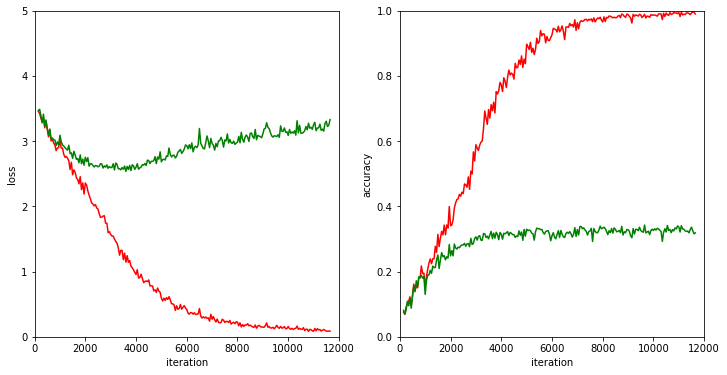

In [15]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,12000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,12000)
acc_graph.set_ylim(0,1)

plt.show() 